In [172]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
from matplotlib import colors as clr
import numpy as np
import sys
import re
import fileinput
from scipy.optimize import curve_fit
import operator
#import scipy as scp


# function to change OUTPUT file into space-separated float fields and parameterise the data using this new format
# line in 'with open' bit is type 'str'

# create a function to get spectral grid data

oldstr = ['0-','1-','2-','3-','4-','5-','6-','7-','8-','9-']
newstr = ['0 -','1 -','2 -','3 -','4 -','5 -','6 -','7 -','8 -','9 -']

def data_read_gaia(f):
    missed_line_inds = []
    temp_data = []
    check = 0
    #number of lines to cut = number of line containing 'convective shell' label - (2 + any additional string lines)
    for line in f:
        for i in range(len(oldstr)):
            line = line.replace(oldstr[i],newstr[i])
        check = check + 1
        for x in range(4,1,-1):
            line = line.replace((x*' '),' ')
        line = line.replace('D','E')
        match_ast = re.search('[**]', line)
        match_inf = re.search('Infinity',line)
        if match_ast or match_inf or (line.strip()==''):
            missed_line_inds.append(check)
            #continue
        else:
            file_data = np.array([float(parameter) for parameter in line.strip().split(' ')])
            temp_data.append(file_data)
    out_all_data = np.array(temp_data)

    print 'Total dataset: ',out_all_data.shape
    return out_all_data

# select the parameter (Teff or log(g) for each array(file)) with which to analyse the filter profiles,
# by setting the other to be constant, using the column number (integer)
def grid_vals_dict(input_arr,col_numb):
    col_vals = []
    col_var_arrs = {}
    # create list of values of the column NOT being examined
    for i in range(len(input_arr[:,(col_numb - 1)])):
        if (input_arr[i,(col_numb - 1)] not in col_vals):
            col_vals.append(input_arr[i,(col_numb - 1)])
    print 'Table column ',col_numb,' values list: ',col_vals
    # create arrays for fixed values of col_numb parameter
    for j in col_vals:
        temp_k_list = []
        for k in range(len(input_arr[:,(col_numb - 1)])):
            if (input_arr[k,(col_numb - 1)] == j):
                temp_k_list.append(input_arr[k,:])
        temp_k_array = np.array(temp_k_list)
        #print 'For column',col_numb,'value of',j,', the array has the following shape: ',temp_k_array.shape
        col_var_arrs[str(j)] = temp_k_array
    print 'Final dictionary length: ',len(col_var_arrs)
    return col_var_arrs, col_vals


# Function to plot multiple Teff or log(g) lines (for 1 filter output ONLY!)
# Input: dictionary of relevant arrays, pyplot axes name (text),fixed input variable values (list of strings)
def dict_2D_plot(input_dict,ax,col_x,col_y,var_names,col_map):
    label_int = 60
    if (col_x == 1):
        label_int = 1
    elif (col_x == 2):
        label_int = 0
        
    plt.gca().set_color_cycle([col_map(j) for j in np.linspace(1, 0, len(input_dict))])
    # grid_vals_dict gives the fixed value as the key for the array
    for i in reversed(sorted(input_dict.iterkeys())):
        ax.plot((input_dict[i])[:,(col_x-1)],(input_dict[i])[:,(col_y-1)],marker='x',linestyle='',label=(var_names[label_int] + '=' + i))
    ax.set_xlabel(var_names[(col_x-1)])
    ax.set_ylabel(var_names[(col_y-1)])
    #plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    #ax.set_title('Stuff',y=1.05)
    plt.show()
    
def diff_grid_dict(dict_Av0,dict_Avne0):
    diff_dict = {}
    # use sets to match keys in dictionaries
    combined_set = set(dict_Av0).intersection(set(dict_Avne0))
    print 'combined set size:',len(combined_set)
    for key_val in combined_set:
        #print key_val
        # use variables to store each key value
        Av0_arr_kv = dict_Av0[key_val]
        Avne0_arr_kv = dict_Avne0[key_val]
        # take the difference of the two sets of filter magnitudes for different calibrations of BCs
        # gives absolute extinction A(X) as numerical output
        diff_arr_kv = Av0_arr_kv - Avne0_arr_kv
        for n in range(len(diff_arr_kv[0,:])):
            if (n == 0 or n == 1):
                # these columns are Teff, log(g) - the inputs for the grid - need to reset these to recover grid
                diff_arr_kv[:,n] = Av0_arr_kv[:,n]
        diff_dict[key_val] = diff_arr_kv
        if (diff_arr_kv.shape != Avne0_arr_kv.shape):
            print 'shape error'
    print 'Raw A(X) dictionary complete'
    return diff_dict

# check Casagrande dictionary - is it just the same as before? Shouldn't be!
def casa_check(A_X_dict,casa_A_X_dict,casa_Teff):
    diff_dict = {}
    offset_arr = []
    temp_arr = []
    combined_set = set(A_X_dict).intersection(set(casa_A_X_dict))
    print 'combined set size:',len(combined_set)
    for key_val in combined_set:
        A_arr_kv = A_X_dict[key_val]
        casa_arr_kv = casa_A_X_dict[key_val]
        for m in range(len(A_arr_kv[:,0])):
            for n in range(len(casa_arr_kv[:,0])):
                # these columns are Teff, log(g) - the inputs for the grid - need to reset these to recover grid
                if ((casa_arr_kv[n,0] == A_arr_kv[m,0] and casa_arr_kv[n,1] == A_arr_kv[m,1])):
                    offset_arr.append(casa_arr_kv[n,0])
                    offset_arr.append(casa_arr_kv[n,1])
                    for j in range(2,5):
                        offset_arr.append(casa_arr_kv[n,j] - A_arr_kv[m,j])
                    temp_arr.append(offset_arr)
        diff_dict[key_val] = np.array(temp_arr)
    return diff_dict
                
# general fits write-out function

def general_fit_number_gen_write(f,func_type,func_coeffs,covar_matrix,filter_str,logg_val,avg_dict):
    frac_list = []
    output_names = ['    Fit coefficients (in order of functions'' arguments):','    Covariance matrix:']
    f.write('Fitting results for ' + str(filter_str) + ' filter, with log(g) = ' + str(logg_val) + '\n')
    f.write('Function type:  ' + func_type + '\n')
    f.write(output_names[0] + '\n')
    f.write(str(func_coeffs) + '\n')
    f.write(output_names[1] + '\n')
    f.write(str(covar_matrix) + '\n')
    f.write('Fractional errors in fit coefficients = {E[(X(i)-E[X(i)])*(X(j)-E[X(j)])]}/{|E[X(i)]*E[X(j)]|}' + '\n')
    f.write('i.e., covariance(i,j)/{coef(i)*coef(j)}' + 2*'\n')
    f.write('Fractional error output:  ' + '\n')
    # write out errors as detailed above
    
    sum_y = 0
    yterm_count = 0
    for i in range(len(func_coeffs)):
        f.write('row ' + str(i+1) + 2*'\t')
        for j in range(len(func_coeffs)):
            # use if statement to avoid repeating terms in symmetrical covariance matrix
            # should result in increasing number of entries for increasing row number
            if (j <= i):
                y = abs(covar_matrix[i][j]/(func_coeffs[i]*func_coeffs[j]))
                f.write(str(y) + '\t')
                yterm_count += 1
                sum_y += y
        f.write('\n')
    f.write('\n')
    avg_y = sum_y/yterm_count
    avg_dict[func_type] = avg_y
    f.write('Average fractional error = ' + str(avg_y) + 2*'\n')
    print 'Average fractional error for ' + func_type + ' = ' + str(avg_y)
    
# Modelling functions below!!!

# single power-law term
def single_poly(xdata,a,b,c):
    y = a*(xdata**b) + c
    return y

# exponential function
def exp_func(xdata,a,b,c):
    y = (a*(np.exp(b*xdata))) + c
    return y

# logarithmic function
def log_func(xdata,a,b,c):
    y = (a*(np.log10(b*xdata))) + c
    return y

# exponential function added to Teff^d
def single_poly_plus_exp_func(xdata,a,b,c,d):
    y = (xdata**d) + (a*(np.exp(b*xdata))) + c
    return y

# exponential function added to d*(Teff^e)
def sppef_2c(xdata,a,b,c,d,e):
    y = (d*(xdata**e)) + (a*(np.exp(b*xdata))) + c
    return y

# functions to reproduce Casagrande & Vandenberg (in prep.) behaviour
def casa_T4_range(Teff_vals,min_val,max_val):
    T4_list = []
    Teff_list = []
    #if (min_val in Teff_vals and max_val in Teff_vals):
    for i in Teff_vals:
        if (min_val <= i <= max_val):
            Teff_list.append(i)
            # T4 defined as Teff*(10^-4)
            T4_list.append(i*(1.0e-4))
    #else:
    T4r = np.array(T4_list)
    Teffr = np.array(Teff_list)
    return Teffr,T4r

# extinction coefficient, R_X = A(X)/E(B-V) ALWAYS!!!
# -> need to find E(B-V) values, then use to compare

# try a function to reduce oppportunities for error for stuff below
# during curve fitting - tests, plots & writes out figure, writes out results of covariance matrix analysis

# curve fitting function
def filter_curve_fit(A_X_zs_gfix,A_X_z2_gfix,key,metal,filter_str):
    if (metal == 'solar'):
        A_X_chosen = A_X_zs_gfix[key]
    elif (metal == 'sol_100'):
        A_X_chosen = A_X_z2_gfix[key]
    else:
        print 'Error! Incorrect metallicity input'
        A_X_chosen = []
        
    if (key == '5.0'):
        # curve-fitting commands - for log(g) = 5.0 ONLY - apply results to other log(g) values
        # store using the following lists:
        exp_fit_A_logg5_list = []
        covarr_A_logg5_ef_list = []
        pow_fit_A_logg5_list = []
        covarr_A_logg5_pow_list = []
        spp_exp_fit_A_logg5_list = []
        covarr_A_logg5_spp_list = []
        for i in range(2,len(A_X_chosen[0,:])):
            exp_fit_A_logg5, covarr_A_logg5_ef = curve_fit(exp_func,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=exp_bounds[i-2])
            pow_fit_A_logg5, covarr_A_logg5_pow = curve_fit(single_poly,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=pow_bounds[i-2])
            spp_exp_fit_A_logg5, covarr_A_logg5_spp = curve_fit(single_poly_plus_exp_func,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=spp_bounds[i-2])

            exp_fit_A_logg5_list.append(exp_fit_A_logg5)
            covarr_A_logg5_ef_list.append(covarr_A_logg5_ef)
            pow_fit_A_logg5_list.append(pow_fit_A_logg5)
            covarr_A_logg5_pow_list.append(covarr_A_logg5_pow)
            spp_exp_fit_A_logg5_list.append(spp_exp_fit_A_logg5)
            covarr_A_logg5_spp_list.append(covarr_A_logg5_spp)
            
            # print fitting results
            print 'Calculating coefficients & covariance matrices for ' + filter_str[i-2] + ' filter'
            
            print 'Exponential fit coefficients: '
            print exp_fit_A_logg5
            print 'Covariance matrix: '
            print covarr_A_logg5_ef

            print 'Teff^(n) fit coefficients: '
            print pow_fit_A_logg5
            print 'Covariance matrix: '
            print covarr_A_logg5_pow

            print 'Teff^(n) + exponential fit coefficients: '
            print spp_exp_fit_A_logg5
            print 'Covariance matrix: '
            print covarr_A_logg5_spp
            
            print 2*'\n'
            
        print 'Number of fit operations = ', len(exp_fit_A_logg5_list)
        print 'List object type: ', type(exp_fit_A_logg5_list)
        # combine lists to store for log(g) != 5.0 function runs
        combined_list = [exp_fit_A_logg5_list,covarr_A_logg5_ef_list,pow_fit_A_logg5_list,covarr_A_logg5_pow_list,spp_exp_fit_A_logg5_list,covarr_A_logg5_spp_list]
        #print combined_list
    print '\n         FITTING OPERATION COMPLETE \n'
    return combined_list

        
# plot & write results
def filter_curve_plot_write(A_X_zs_gfix,A_X_z2_gfix,combined_list,key,metal,extras,exp_bounds,pow_bounds,spp_bounds,filter_str,folder,graph_fold,casa_opt,multiplot_file,zoom_min=None,zoom_max=None):
    if (metal == 'solar'):
        A_X_chosen = A_X_zs_gfix[key]
        casa_chosen = casa_arr_zs
    elif (metal == 'sol_100'):
        A_X_chosen = A_X_z2_gfix[key]
        casa_chosen = casa_arr_z2
    else:
        print 'Error! Incorrect metallicity input'
        A_X_chosen = []
    
    if (zoom_min is not None and zoom_max is not None):
        extras += ('_zoom_' + str(int(zoom_min)) + 'K_' + str(int(zoom_max)) + 'K')
    # First, double-check number of columns
    #if (len(A_X_chosen[0,:]) == len(A_X_fit[0,:])):
    #    print 'Number of columns check passed'
    
    
    # Hubble data: easier to use subplots -> add option
    if (multiplot_file == 'y'):
        plot_dir_str_i = None
        data_dir_str_i = None
        fig, axs = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
        axs = axs.ravel()
        # Write out to new file: first 'with' statement empties the file to be written into later
        data_dir_str_i = folder + '/Teff_AHub_gaia_gen_fit_logg=' + key + '_' + metal + '_' + extras + '_numbers.txt'
        with open (data_dir_str_i,'w') as f:
            f.close()
        # Iteration for changes BETWEEN filters !!!
        for i in range(2,len(A_X_chosen[0,:])):
            
            # curve_fit(exp_func,A_X_fit[:,0],A_X_fit[:,i], p0=None, sigma=None,bounds=exp_bounds[i-2])
            # curve_fit(single_poly,A_X_fit[:,0],A_X_fit[:,i], p0=None, sigma=None,bounds=pow_bounds[i-2])
            # curve_fit(single_poly_plus_exp_func,A_X_fit[:,0],A_X_fit[:,i], p0=None, sigma=None,bounds=spp_bounds[i-2])
            
            # curve-fitting commands - for log(g) = 5.0 ONLY - apply results to other log(g) values
            # use lists filled in before (for log(g) = 5.0) to provide fit-curve data
            exp_fit_A_logg5 = (combined_list[0])[i-2]
            covarr_A_logg5_ef = (combined_list[1])[i-2]
            pow_fit_A_logg5 = (combined_list[2])[i-2]
            covarr_A_logg5_pow = (combined_list[3])[i-2]
            spp_exp_fit_A_logg5 = (combined_list[4])[i-2]
            covarr_A_logg5_spp = (combined_list[5])[i-2]
            
            # check that fitting numbers are retained
            if (i == 2 and key != '5.0'):
                print 'Exponential fit coefficients (should be reused): '
                print exp_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_ef

                print 'Teff^(n) fit coefficients (should be reused): '
                print pow_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_pow

                print 'Teff^(n) + exponential fit coefficients (should be reused): '
                print spp_exp_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_spp
                
                print 2*'\n'
                
            axs[i-2].set_xlabel(var_names_comb[0])
            axs[i-2].set_ylabel(var_names_comb[i])
            # - 0.01 (data - 0.01) *max(A_X_chosen[:,i])*max(data)
            # + 0.01 (data + 0.01) *max(A_X_chosen[:,i])*max(data)
            axs[i-2].plot(A_X_chosen[:,0],A_X_chosen[:,i],'k',marker='x',linestyle='',label='Data')
            axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.01),'k',linestyle='--',label='Data lower accuracy limit (data - 0.01)')
            axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
            #axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.02),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.02)')
            #axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.02),'k',linestyle='-.',label='Data upper accuracy limit (data + 0.02)')
            axs[i-2].plot(A_X_chosen[:,0],exp_func(A_X_chosen[:,0],*exp_fit_A_logg5),'m',label=fit_types[0])
            axs[i-2].plot(A_X_chosen[:,0],single_poly(A_X_chosen[:,0],*pow_fit_A_logg5),'g',label=fit_types[1])
            axs[i-2].plot(A_X_chosen[:,0],single_poly_plus_exp_func(A_X_chosen[:,0],*spp_exp_fit_A_logg5),'r',label=fit_types[2])
            if (zoom_min is not None and zoom_max is not None):
                axs[i-2].set_xlim(zoom_min,zoom_max)
            title_str = filter_str[i-2] + ' filter'
            axs[i-2].set_title(title_str, y=1.02)
            
            avg_dict = {}
            with open (data_dir_str_i,'a') as f:
                print '\n    Writing log(g)=' + key + ', Z = ' + metal + ' model for ' + filter_str[i-2] + ' filter'
                general_fit_number_gen_write(f,fit_types[0],exp_fit_A_logg5, covarr_A_logg5_ef,filter_str[i-2],float(key),avg_dict)
                general_fit_number_gen_write(f,fit_types[1],pow_fit_A_logg5, covarr_A_logg5_pow,filter_str[i-2],float(key),avg_dict)
                general_fit_number_gen_write(f,fit_types[2],spp_exp_fit_A_logg5, covarr_A_logg5_spp,filter_str[i-2],float(key),avg_dict)

                # write results of comparison of averages
                sorted_avg = sorted(avg_dict.items(), key=operator.itemgetter(1))
                f.write('RANKED MEAN FRACTIONAL ERRORS (best to worst) :   ' + '\n')
                for j in sorted_avg:
                    f.write("{: <40}".format(str(j[0])) + 2*'\t' + str(j[1]) + '\n')
                f.close()
                #_0.02
        plot_dir_str_i = folder + '/' + graph_fold + '/AHub_logg=' + key + '_' + metal + '_' + extras + '_Teff_fit_plot.pdf'
        
            
            
        sup_title_str = 'Extinction plots for log(g) = ' + key + ', Z = Z' + metal
        fig.suptitle(sup_title_str,size=16)
        fig.tight_layout()
        fig.subplots_adjust(top=0.92) # 0.88
        plt.show()
        fig.savefig(plot_dir_str_i, bbox_inches='tight')

    else:
        # Iteration for changes BETWEEN filters !!!
        # i.e., should produce 3 versions of each output each time the function is called
        for i in range(2,len(A_X_chosen[0,:])):
            # empty directory string - avoid potential concatonation
            plot_dir_str_i = None
            data_dir_str_i = None
            # curve-fitting commands
            exp_fit_A_logg5 = (combined_list[0])[i-2]
            covarr_A_logg5_ef = (combined_list[1])[i-2]
            pow_fit_A_logg5 = (combined_list[2])[i-2]
            covarr_A_logg5_pow = (combined_list[3])[i-2]
            spp_exp_fit_A_logg5 = (combined_list[4])[i-2]
            covarr_A_logg5_spp = (combined_list[5])[i-2]

            # check that fitting numbers are retained
            if (i == 2):
                print 'Exponential fit coefficients (should be reused): '
                print exp_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_ef

                print 'Teff^(n) fit coefficients (should be reused): '
                print pow_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_pow

                print 'Teff^(n) + exponential fit coefficients (should be reused): '
                print spp_exp_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_spp
                
                print 2*'\n'

            # Construct directories, files to save plots,data - i.e. construct strings
            # String format should be: 'gaia_spectra/gaia_graphs/AGrp_logg=5.0_Teff_fit_plot.pdf' (example case)
            if (casa_opt == 'y' and i == 2):
                folder += '_casa'
                graph_fold += '_casa'

            plot_dir_str_i = folder + '/' + graph_fold + '/A' + filter_str[i-2] + '_logg=' + key + '_' + metal + '_' + extras + '_Teff_fit_plot'
            data_dir_str_i = folder + '/Teff_A' + filter_str[i-2] + '_gen_fit_logg=' + key + '_' + metal + '_' + extras + '_numbers'
            # separate Casagrande data
            if (casa_opt == 'y'): # and i == 2
                plot_dir_str_i += '_casa'
                data_dir_str_i += '_casa'
            plot_dir_str_i += '.pdf'
            data_dir_str_i += '.txt'
            
            # plot commands
            fig, ax = plt.subplots()
            ax.set_xlabel(var_names[0])
            ax.set_ylabel(var_names[i])
            if (casa_opt == 'y'):
                ax.plot(A_X_chosen[:,0],A_X_chosen[:,i],'k',marker='x',linestyle='-',label='Data')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.01),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.01)')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
                ax.plot(casa_chosen[:,0],casa_chosen[:,i],'b',marker='x',linestyle='-',label='Casagrande data')
                if (zoom_min is not None and zoom_max is not None):
                    ax.set_xlim(zoom_min,zoom_max)
            else:
                # - 0.01 (data - 0.01) *max(A_X_chosen[:,i])*max(data)
                # + 0.01 (data + 0.01) *max(A_X_chosen[:,i])*max(data)
                ax.plot(A_X_chosen[:,0],A_X_chosen[:,i],'k',marker='x',linestyle='',label='Data')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.01),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.01)')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
                ax.plot(A_X_chosen[:,0],exp_func(A_X_chosen[:,0],*exp_fit_A_logg5),'m',label=fit_types[0])
                ax.plot(A_X_chosen[:,0],single_poly(A_X_chosen[:,0],*pow_fit_A_logg5),'g',label=fit_types[1])
                ax.plot(A_X_chosen[:,0],single_poly_plus_exp_func(A_X_chosen[:,0],*spp_exp_fit_A_logg5),'r',label=fit_types[2])
                if (zoom_min is not None and zoom_max is not None):
                    ax.set_xlim(zoom_min,zoom_max)
            
            plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
            plt.show()
            fig.savefig(plot_dir_str_i, bbox_inches='tight')

            # data file write commands
            
            avg_dict = {}
            with open (data_dir_str_i,'w') as f:
                print '\n    Writing log(g)=' + key + ', Z = ' + metal + ' model'
                general_fit_number_gen_write(f,fit_types[0],exp_fit_A_logg5, covarr_A_logg5_ef,filter_str[i-2],float(key),avg_dict)
                general_fit_number_gen_write(f,fit_types[1],pow_fit_A_logg5, covarr_A_logg5_pow,filter_str[i-2],float(key),avg_dict)
                general_fit_number_gen_write(f,fit_types[2],spp_exp_fit_A_logg5, covarr_A_logg5_spp,filter_str[i-2],float(key),avg_dict)

                # write results of comparison of averages
                sorted_avg = sorted(avg_dict.items(), key=operator.itemgetter(1))
                f.write('RANKED MEAN FRACTIONAL ERRORS (best to worst) :   \n')
                for j in sorted_avg:
                    f.write("{: <40}".format(str(j[0])) + 2*'\t' + str(j[1]) + '\n')
                f.close()
                
            #with open (folder + '/coeffs_summary_cas.txt','a') as sf:
                #sf.write('Fit coefficients summary')
                #sf.write('log(g) = ' + key + ', Z = ' + metal + ', ' + filter_str[i-2] + ' filter ' + 3*'\t' + str(pow_fit_A_logg5) + '\n')
            #sf.close()
            print 'Writing complete for ' + filter_str[i-2] + ' filter'
    print '\n Writing complete for log(g) = ' + key + ', Z = ' + metal + ' configuration, END OF FUNCTION WRITING!!!'

def comb_hub_gaia_dict(Ahub,Agaia):
    comb_dict = {}
    for key in sorted(Ahub.iterkeys()):
        #print key
        hub_arr = Ahub[key]
        #print hub_arr_zs.shape
        #print len(hub_arr_zs[:,0])
        gaia_arr = Agaia[key]
        comb_arr = np.zeros((len(hub_arr[:,0]),(len(hub_arr[0,:]) + 3)))
        comb_arr[:,:-3] = hub_arr
        comb_arr[:,-3:] = gaia_arr[:,2:5]
        #comb_arr_zs = np.append(hub_arr_zs,gaia_arr_zs[:,2:5])
        comb_dict[key] = comb_arr
    return comb_dict

# extract coefficients into a summary file
def make_coeffs_summary(directory,infile,outfile,filter_names,logg_val,metal,writing_type):
    locin = directory + infile
    locout = directory + outfile

    with open(locin,'r') as inputf, open(locout,writing_type) as outputf:
        n = 0
        copy_bool = False
        #outputf.write('Coefficients for Teff power law: \n\n')
        #if (n <= (len(filter_names)-1)):
        #copy_bool = False
        for line in inputf:
            #if ('Fitting results for' in line.strip()): == '    Covariance matrix:'
                #outputf.write(line)
            if (line.strip() == 'Function type:  Power law of Teff, fitted'):
                copy_bool = True
                n += 1
            elif ('Covariance' in line.strip()):
                copy_bool = False
            elif copy_bool:
                if ('Fit coefficients (in order of functions arguments)' in line.strip()):
                    continue
                else:
                    print n
                    outputf.write(filter_names[n-1] + ' filter, with  log(g) = ' + logg_val + ' and Z = Z' + metal + ': \t\t' + line)
                    

        outputf.write('#\n#\n')
        inputf.close()
        outputf.close()

# cutoff - tailflick evasion
def Teff_cutoff_dict(old_dict,criterion):
    new_dict = {}
    #print len(new_dict)
    x = 0
    for key in sorted(old_dict.iterkeys()):
        temp_arr_list = []
        #print new_dict[key].shape
        for i in range(len(old_dict[key][:,0])):
            if (old_dict[key][i,0] >= criterion):
                temp_arr_list.append(old_dict[key][i,:])
                #print 'Teff value too low: ',new_dict[key][i,0]
            elif(x == 0 and old_dict[key][i,0] < criterion):
                print old_dict[key][i,0]
        new_dict[key] = np.array(temp_arr_list)
        x += 1
    print x
    return new_dict

# low-Teff: log(g) affects A(filter)/A(V), i.e. A(Teff) becomes A(Teff,log(g))
# -> find law for log(g) effects
# N.B.: log(g) = consts. x (M(R*)/(R*)^2)
# Linear? Girardi et al. (2008) use giant Teff law: Teff(log(g)) = 3250 + 500log(g)
# For my values of log(g) (= 0 to 5), this gives a range of (3250 <= Teff <= 5750)
# Take our working definition of 0.01 'error' as a limit on log(g) effects

def low_logg_law_trunc(whole_dict,err_lim):
    # use log(g)-keyed dictionaries to save memory
    # get log(g) = 5 dictionary (the one the model is fitted to) as the reference data
    a = whole_dict['5.0']
    for key in sorted(whole_dict.iterkeys()):
        k = ''
        if (key != '5.0'):
            b = whole_dict[key]
                # find the range for which data spread greater than 0.01   
            for i in range(len(b[:,0])): # row number iteration
                x = 0
                for j in range(2,len(b[0,:])): # column number iteration
                    if (x != 0):
                        k = '\t'
                    # data spread condition
                    dif = a[i,j]-b[i,j]
                    if (abs(dif) >= err_lim):
                        print k + 'Teff=',b[i,0],', log(g)=',b[i,1],', column ',(j+1),', difference=',dif
                        k = ''
                        x += 1

def casa_Rfil_eq(t4_range,metal,a0,a1,a2,a3):
    if (metal == 'solar'):
        FeH = 0
    elif (metal == 'sol_100'):
        FeH = 2
    Rfil = a0 + (t4_range*(a1 + (a2*t4_range))) + (a3*FeH)
    return (Rfil/3.1) # = Afil/Av

def casa_build(teff_range,Rfil_G,Rfil_Gbp,Rfil_Grp):
    casa_arr = np.zeros((teff_range.size,5))
    casa_arr[:,0] = teff_range
    casa_arr[:,2] = Rfil_G
    casa_arr[:,3] = Rfil_Gbp
    casa_arr[:,4] = Rfil_Grp
    return casa_arr
   
# END OF FUNCTION DEFINITIONS

print 'modules loaded & functions compiled'

modules loaded & functions compiled


In [159]:
# N.B.: using cgs unit
print 'Gaia data read '
print '\n'

# Standard output
with open ("gaia_spectra/OUTPUT_Av0_zsolar") as Av0zs:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_data = data_read_gaia(Av0zs)

with open ("gaia_spectra/OUTPUT_Av1_zsolar") as Av1zs:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_data = data_read_gaia(Av1zs)
    
with open ("gaia_spectra/OUTPUT_Av0_z10-2") as Av0z2:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_data = data_read_gaia(Av0z2)
      
with open ("gaia_spectra/OUTPUT_Av1_z10-2") as Av1z2:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_data = data_read_gaia(Av1z2)

# Casagrande files
with open ("gaia_spectra_casa/casa_output_A0_zsolar") as casAv0zs:
    print '\n    Reading A(v) = 0, Z = Zsolar Casagrande & Vandenberg model'
    casa_Av0zs_data = data_read_gaia(casAv0zs)
    
with open ("gaia_spectra_casa/casa_output_A1_zsolar") as casAv1zs:
    print '\n    Reading A(v) = 1, Z = Zsolar Casagrande & Vandenberg model'
    casa_Av1zs_data = data_read_gaia(casAv1zs)
    
with open ("gaia_spectra_casa/casa_output_A0_z10-2") as casAv0z2:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) Casagrande & Vandenberg model'
    casa_Av0z2_data = data_read_gaia(casAv0z2)
    
with open ("gaia_spectra_casa/casa_output_A1_z10-2") as casAv1z2:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) Casagrande & Vandenberg model'
    casa_Av1z2_data = data_read_gaia(casAv1z2)

# Casagrande comparison: open files at relevant Rv values
# Rv = 2.740: Gaia G filter
with open ("gaia_spectra_casa/OUTPUT_2_74_A0_zsolar") as Av0zs_2740:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_2740_data = data_read_gaia(Av0zs_2740)

with open ("gaia_spectra_casa/OUTPUT_2_74_A1_zsolar") as Av1zs_2740:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_2740_data = data_read_gaia(Av1zs_2740)
    
with open ("gaia_spectra_casa/OUTPUT_2_74_A0_z10-2") as Av0z2_2740:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_2740_data = data_read_gaia(Av0z2_2740)
      
with open ("gaia_spectra_casa/OUTPUT_2_74_A1_z10-2") as Av1z2_2740:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_2740_data = data_read_gaia(Av1z2_2740)
    
# Rv = 3.374: Gaia Gbp filter
with open ("gaia_spectra_casa/OUTPUT_3_374_A0_zsolar") as Av0zs_3374:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_3374_data = data_read_gaia(Av0zs_3374)

with open ("gaia_spectra_casa/OUTPUT_3_374_A1_zsolar") as Av1zs_3374:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_3374_data = data_read_gaia(Av1zs_3374)
    
with open ("gaia_spectra_casa/OUTPUT_3_374_A0_z10-2") as Av0z2_3374:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_3374_data = data_read_gaia(Av0z2_3374)
      
with open ("gaia_spectra_casa/OUTPUT_3_374_A1_z10-2") as Av1z2_3374:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_3374_data = data_read_gaia(Av1z2_3374)
    
# Rv = 2.035: Gaia Grp filter
with open ("gaia_spectra_casa/OUTPUT_2_035_A0_zsolar") as Av0zs_2035:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_2035_data = data_read_gaia(Av0zs_2035)

with open ("gaia_spectra_casa/OUTPUT_2_035_A1_zsolar") as Av1zs_2035:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_2035_data = data_read_gaia(Av1zs_2035)
    
with open ("gaia_spectra_casa/OUTPUT_2_035_A0_z10-2") as Av0z2_2035:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_2035_data = data_read_gaia(Av0z2_2035)
      
with open ("gaia_spectra_casa/OUTPUT_2_035_A1_z10-2") as Av1z2_2035:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_2035_data = data_read_gaia(Av1z2_2035)

    
    
# Note: Teff is column 1, log(g) is column 2
print '****Creating arrays****'
print '****Separating data into arrays by log(g) values****'

# dictionaries (Cardelli et al. Rv = 3.1)
Av0zs_logg_fix,Av0zs_logg_vals = grid_vals_dict(Av0zs_data,2)
Av1zs_logg_fix,Av1zs_logg_vals = grid_vals_dict(Av1zs_data,2)
Av0z2_logg_fix,Av0z2_logg_vals = grid_vals_dict(Av0z2_data,2)
Av1z2_logg_fix,Av1z2_logg_vals = grid_vals_dict(Av1z2_data,2)
# Casagrande dictionaries
# Casagrande Rv profile
casa_Av0zs_logg_fix,casa_Av0zs_logg_vals = grid_vals_dict(casa_Av0zs_data,2)
casa_Av1zs_logg_fix,casa_Av1zs_logg_vals = grid_vals_dict(casa_Av1zs_data,2)
casa_Av0z2_logg_fix,casa_Av0z2_logg_vals = grid_vals_dict(casa_Av0z2_data,2)
casa_Av1z2_logg_fix,casa_Av1z2_logg_vals = grid_vals_dict(casa_Av1z2_data,2)


print '****Separating data into arrays by Teff values****'
Av0zs_Teff_fix,Av0zs_Teff_vals = grid_vals_dict(Av0zs_data,1)
Av1zs_Teff_fix,Av1zs_Teff_vals = grid_vals_dict(Av1zs_data,1)
Av0z2_Teff_fix,Av0z2_Teff_vals = grid_vals_dict(Av0z2_data,1)
Av1z2_Teff_fix,Av1z2_Teff_vals = grid_vals_dict(Av1z2_data,1)


print '****Finished arrays****'
#print type(Av0zs_Teff_vals[0])
A_X_zs_gfix = diff_grid_dict(Av0zs_logg_fix,Av1zs_logg_fix)
A_X_z2_gfix = diff_grid_dict(Av0z2_logg_fix,Av1z2_logg_fix)

Agaia_zs_Teff_fix = diff_grid_dict(Av0zs_Teff_fix,Av1zs_Teff_fix)
Agaia_z2_Teff_fix = diff_grid_dict(Av0z2_Teff_fix,Av1z2_Teff_fix)

Agaia_zs = A_X_zs_gfix
Agaia_z2 = A_X_z2_gfix

casa_A_X_zs_gfix = diff_grid_dict(casa_Av0zs_logg_fix,casa_Av1zs_logg_fix)
casa_A_X_z2_gfix = diff_grid_dict(casa_Av0z2_logg_fix,casa_Av1z2_logg_fix)


Teff_5_zs = (A_X_zs_gfix['5.0'])[:,0]
# casagrande Teff ranges
casa_Teff,casa_T4 = casa_T4_range(((A_X_zs_gfix['5.0'])[:,0]),5250,7000)
print casa_T4

# casagrande data
# zsolar
Rfil_G_zs = casa_Rfil_eq(casa_T4,'solar',1.4013,3.1406,-1.5626,-0.0101)
Rfil_Gbp_zs = casa_Rfil_eq(casa_T4,'solar',1.7895,4.2355,-2.7071,-0.0253)
Rfil_Grp_zs = casa_Rfil_eq(casa_T4,'solar',1.8593,0.3985,-0.1771,0.0026)
# zsolar/100
Rfil_G_z2 = casa_Rfil_eq(casa_T4,'sol_100',1.4013,3.1406,-1.5626,-0.0101)
Rfil_Gbp_z2 = casa_Rfil_eq(casa_T4,'sol_100',1.7895,4.2355,-2.7071,-0.0253)
Rfil_Grp_z2 = casa_Rfil_eq(casa_T4,'sol_100',1.8593,0.3985,-0.1771,0.0026)

casa_arr_zs = casa_build(casa_Teff,Rfil_G_zs,Rfil_Gbp_zs,Rfil_Grp_zs)
casa_arr_z2 = casa_build(casa_Teff,Rfil_G_z2,Rfil_Gbp_z2,Rfil_Grp_z2)

print casa_arr_zs.shape,casa_arr_z2.shape
print casa_arr_zs[:,2],casa_arr_z2[:,2]


casa_zs_check = casa_check(A_X_zs_gfix,casa_A_X_zs_gfix,casa_Teff)
casa_z2_check = casa_check(A_X_z2_gfix,casa_A_X_z2_gfix,casa_Teff)

print 'checker', len(casa_zs_check)
print casa_zs_check['0.0']


var_names = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(G)/A(V)$','$A(G_{bp})/A(V)$','$A(G_{rp})/A(V)$','log($T_{eff}$ / K)']

# strings describing functions being fitted to the data
fit_types = []

fit_types.append('Exponential function of Teff, fitted')
fit_types.append('Power law of Teff, fitted')
fit_types.append('Power law + exponential function of Teff, fitted')

with open('dict_example.txt','w') as f:
    for key in sorted(Agaia_zs.iterkeys()):
        f.write('Dictionary for log(g) = ' + key + '\n')
        np.savetxt(f,Agaia_zs[key],fmt='%6.1f %4.1f %6.3f %6.3f %6.3f')#,delimiter='   '
        f.write('\n')
    f.close()
    
print 'Variable data arrays organized'

Gaia data read 



    Reading A(v) = 0, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 1, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 5L)

    Reading A(v) = 1, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z = Zsolar Casagrande & Vandenberg model
Total dataset:  (84L, 5L)

    Reading A(v) = 1, Z = Zsolar Casagrande & Vandenberg model
Total dataset:  (84L, 5L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) Casagrande & Vandenberg model
Total dataset:  (84L, 5L)

    Reading A(v) = 1, Z = (10^(-2) Zsolar) Casagrande & Vandenberg model
Total dataset:  (84L, 5L)

    Reading A(v) = 0, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 1, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 5L)

    Reading A(v) = 1, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z =

List of lists of arrays, length  6 


Exponential fit coefficients (should be reused): 
[ -6.53428506e-01  -2.26385788e-04   1.01965672e+00]
Covariance matrix (should be reused): 
[[  2.79338034e-04   7.70976187e-08   6.76584212e-06]
 [  7.70976187e-08   2.57620527e-11   3.87030584e-09]
 [  6.76584212e-06   3.87030584e-09   1.79492898e-06]]
Teff^(n) fit coefficients (should be reused): 
[ -6.78195568e+03  -1.21016758e+00   1.04529155e+00]
Covariance matrix (should be reused): 
[[  1.26424117e+06   2.26449587e+01   1.53556219e+00]
 [  2.26449587e+01   4.06236079e-04   2.80097118e-05]
 [  1.53556219e+00   2.80097118e-05   2.54851045e-06]]
Teff^(n) + exponential fit coefficients (should be reused): 
[ -7.28409983e-01  -3.20581458e-04  -2.83317722e-01   2.54424691e-02]
Covariance matrix (should be reused): 
[[  1.41089591e-04   5.49775886e-08   5.13844979e-05  -3.71740513e-06]
 [  5.49775886e-08   2.87775479e-11   4.03664687e-08  -2.95850851e-09]
 [  5.13844979e-05   4.03664687e-08   8.290

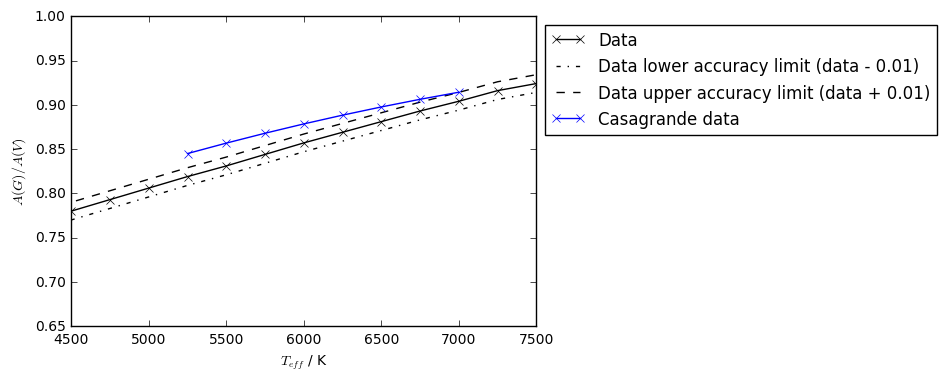


    Writing log(g)=2.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.000284456515716
Average fractional error for Power law of Teff, fitted = 0.00512735525587
Average fractional error for Power law + exponential function of Teff, fitted = 0.000463682917249
Writing complete for G filter


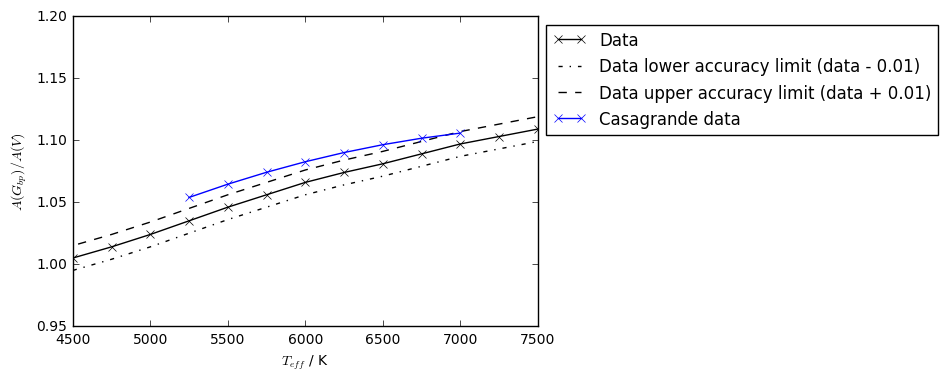


    Writing log(g)=2.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.000859484759811
Average fractional error for Power law of Teff, fitted = 0.00763047244793
Average fractional error for Power law + exponential function of Teff, fitted = 0.00154964086044
Writing complete for Gbp filter


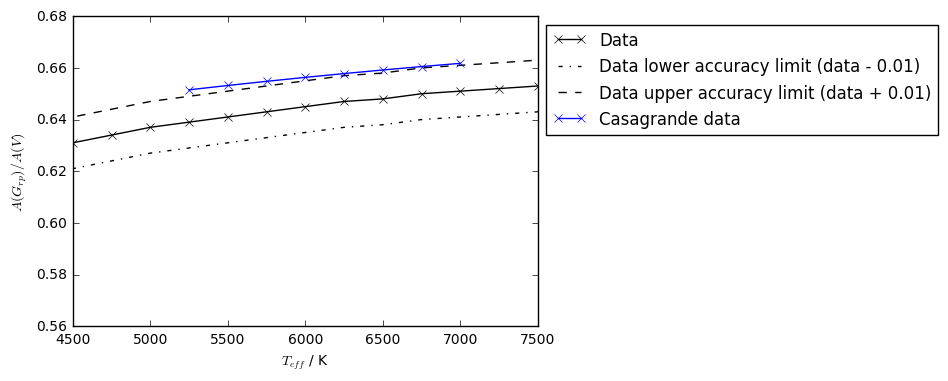


    Writing log(g)=2.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.000368906681744
Average fractional error for Power law of Teff, fitted = 0.00352220942863
Average fractional error for Power law + exponential function of Teff, fitted = 0.00035492237912
Writing complete for Grp filter

 Writing complete for log(g) = 2.0, Z = solar configuration, END OF FUNCTION WRITING!!!


'\nA_X_zs_2740_gfix\nA_X_z2_2740_gfix\n\nA_X_zs_3374_gfix\nA_X_z2_3374_gfix\n\nA_X_zs_2035_gfix\nA_X_z2_2035_gfix'

In [151]:
# GAIA FILTER PLOTTING
# filter string names
gaia_filter_str = ['G','Gbp','Grp']
# curve fitting coefficients' bounds
exp_bounds_G = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_G = ([-1.0e+05, -3., -5.], [1., 1., 5.])
spp_bounds_G = ([-1.0e+02, -1., -5., -3.], [1., 1., 5., 3.])

exp_bounds_Gbp = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_Gbp = ([-1.0e+03, -3., -4.], [1., 3., 4.])
spp_bounds_Gbp = ([-1.0e+02, -1., -5., -3.], [1., 1., 5., 3.])

exp_bounds_Grp = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_Grp = ([-1.0e+05, -4., -6.], [1., 4., 6.])
spp_bounds_Grp = ([-1.0e+02, -1., -5., -3.], [1., 1., 5., 3.])

exp_bounds = [exp_bounds_G,exp_bounds_Gbp,exp_bounds_Grp]
pow_bounds = [pow_bounds_G,pow_bounds_Gbp,pow_bounds_Grp]
spp_bounds = [spp_bounds_G,spp_bounds_Gbp,spp_bounds_Grp]

#print exp_bounds
#print pow_bounds
#print spp_bounds

# call function to general results

#metal_choice = 'sol_100'
#combined_list_coef_cov = filter_curve_fit(A_X_zs_gfix,A_X_z2_gfix,'5.0','solar',gaia_filter_str) # Leave key at '5.0'!!!
print 'List of lists of arrays, length ',len(combined_list_coef_cov),'\n\n'
filter_curve_plot_write(A_X_zs_gfix,A_X_z2_gfix,combined_list_coef_cov,'2.0','solar','',exp_bounds,pow_bounds,spp_bounds,gaia_filter_str,'gaia_spectra','gaia_graphs','y','n',4500,7500)


In [51]:
#print combined_list_all[1]

[array([[  2.79338034e-04,   7.70976187e-08,   6.76584212e-06],
       [  7.70976187e-08,   2.57620527e-11,   3.87030584e-09],
       [  6.76584212e-06,   3.87030584e-09,   1.79492898e-06]]), array([[  2.07691944e-04,   8.88355531e-08,   8.04348948e-06],
       [  8.88355531e-08,   5.13881156e-11,   9.76299771e-09],
       [  8.04348948e-06,   9.76299771e-09,   4.84155446e-06]]), array([[  1.49136285e-05,   2.10909954e-08,   3.38301239e-07],
       [  2.10909954e-08,   3.56808576e-11,   9.52798945e-10],
       [  3.38301239e-07,   9.52798945e-10,   7.96362536e-08]])]


In [179]:
# Hubble data read
# N.B.: using cgs unit
print 'Hubble data read'
print '\n'

with open ("HubWFC/H_OUTPUT_Av0_zsolar") as Av0zs:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_hub_data = data_read_gaia(Av0zs)

with open ("HubWFC/H_OUTPUT_Av1_zsolar") as Av1zs:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_hub_data = data_read_gaia(Av1zs)

with open ("HubWFC/H_OUTPUT_Av0_z10-2") as Av0z2:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_hub_data = data_read_gaia(Av0z2)

with open ("HubWFC/H_OUTPUT_Av1_z10-2") as Av1z2:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_hub_data = data_read_gaia(Av1z2)

# Note: Teff is column 1, log(g) is column 2
print '****Creating arrays****'
print '****Separating data into arrays by log(g) values****'
# dictionaries
Av0zs_logg_fix,Av0zs_logg_vals = grid_vals_dict(Av0zs_hub_data,2)
Av1zs_logg_fix,Av1zs_logg_vals = grid_vals_dict(Av1zs_hub_data,2)
Av0z2_logg_fix,Av0z2_logg_vals = grid_vals_dict(Av0z2_hub_data,2)
Av1z2_logg_fix,Av1z2_logg_vals = grid_vals_dict(Av1z2_hub_data,2)

""""""
print '****Separating data into arrays by Teff values****'
Av0zs_Teff_fix,Av0zs_Teff_vals = grid_vals_dict(Av0zs_hub_data,1)
Av1zs_Teff_fix,Av1zs_Teff_vals = grid_vals_dict(Av1zs_hub_data,1)
Av0z2_Teff_fix,Av0z2_Teff_vals = grid_vals_dict(Av0z2_hub_data,1)
Av1z2_Teff_fix,Av1z2_Teff_vals = grid_vals_dict(Av1z2_hub_data,1)

Ahub_zs_Teff_fix = diff_grid_dict(Av0zs_Teff_fix,Av1zs_Teff_fix)
Ahub_z2_Teff_fix = diff_grid_dict(Av0z2_Teff_fix,Av1z2_Teff_fix)

print '****Finished arrays****'

A_X_zs_gfix = diff_grid_dict(Av0zs_logg_fix,Av1zs_logg_fix)
A_X_z2_gfix = diff_grid_dict(Av0z2_logg_fix,Av1z2_logg_fix)

Ahub_zs = A_X_zs_gfix
Ahub_z2 = A_X_z2_gfix

comb_dict_zs = comb_hub_gaia_dict(Ahub_zs,Agaia_zs)
comb_dict_z2 = comb_hub_gaia_dict(Ahub_z2,Agaia_z2)

comb_dict_Teff_zs = comb_hub_gaia_dict(Ahub_zs_Teff_fix,Agaia_zs_Teff_fix)
comb_dict_Teff_z2 = comb_hub_gaia_dict(Ahub_z2_Teff_fix,Agaia_z2_Teff_fix)

# write out array of combined Hubble & Gaia data
#with open('AHub_vals_solar_gfix','w') as f:
#    for key in A_X_zs_gfix:
#        f.write('log(g) = ' + key + ', Z=Zsol')
#        f.write(A_X_zs_gfix[key])
        
        
print type(A_X_z2_gfix)
print type(A_X_z2_gfix['0.0'])
print comb_dict_zs['0.0'].shape
print len(comb_dict_zs)

print comb_dict_Teff_zs['5000.0'].shape
print len(comb_dict_Teff_zs)

var_names = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(f218w)/A(V)$','$A(f225w)/A(V)$','$A(f275w)/A(V)$','$A(f300x)/A(V)$','$A(f336w)/A(V)$','$A(f390w)/A(V)$','$A(f438w)/A(V)$','$A(f475w)/A(V)$','$A(f555w)/A(V)$','$A(f606w)/A(V)$','$A(f625w)/A(V)$','$A(f775w)/A(V)$','$A(f814w)/A(V)$']

# 'log($T_{eff}$ / K)'

# Note: Teff is column 1, log(g) is column 2
print '****Creating arrays****'
print '****Separating data into arrays by log(g) values****'
# dictionaries
Av0zs_logg_fix,Av0zs_logg_vals = grid_vals_dict(Av0zs_data,2)
Av1zs_logg_fix,Av1zs_logg_vals = grid_vals_dict(Av1zs_data,2)
Av0z2_logg_fix,Av0z2_logg_vals = grid_vals_dict(Av0z2_data,2)
Av1z2_logg_fix,Av1z2_logg_vals = grid_vals_dict(Av1z2_data,2)
#print Av0z2_logg_fix['5.0']
#print A_X_z2_gfix['0.0'].shape
#print (A_X_z2_gfix['0.0'])[0,:].shape

# filter string names
hub_filter_str = ['f218w','f225w','f275w','f300x','f336w','f390w','f438w','f475w','f555w','f606w','f625w','f775w','f814w']
gaia_filter_str = ['G','Gbp','Grp']
comb_filter_str = hub_filter_str + gaia_filter_str

var_names_comb = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(f218w)/A(V)$','$A(f225w)/A(V)$','$A(f275w)/A(V)$','$A(f300x)/A(V)$','$A(f336w)/A(V)$','$A(f390w)/A(V)$','$A(f438w)/A(V)$','$A(f475w)/A(V)$','$A(f555w)/A(V)$','$A(f606w)/A(V)$','$A(f625w)/A(V)$','$A(f775w)/A(V)$','$A(f814w)/A(V)$','$A(G)/A(V)$','$A(G_{bp})/A(V)$','$A(G_{rp})/A(V)$']

comb_dict_zs_4500K = Teff_cutoff_dict(comb_dict_zs,4500.0)
comb_dict_z2_4500K = Teff_cutoff_dict(comb_dict_z2,4500.0)

for key in sorted(comb_dict_z2_4500K.iterkeys()):
    print comb_dict_z2_4500K[key].shape
print 'Variable data arrays organized'

Hubble data read



    Reading A(v) = 0, Z = Zsolar model
Total dataset:  (476L, 15L)

    Reading A(v) = 1, Z = Zsolar model
Total dataset:  (476L, 15L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 15L)

    Reading A(v) = 1, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 15L)
****Creating arrays****
****Separating data into arrays by log(g) values****
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
****Separating data into arrays by Teff values****
Table column  1  values list:  [3500.0, 3750.0, 4000.0, 4250.0, 4500.0, 4750.0, 5000.0, 5250.0, 5

TypeError: unhashable type: 'numpy.ndarray'

In [25]:
# HUBBLE FILTER PLOTTING

#print comb_filter_str
""""""
# curve fitting coefficients' bounds
exp_bounds_f218w = ([-100., -2., -5.], [1., 2., 5.])
pow_bounds_f218w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
spp_bounds_f218w = ([-1.0e+03, -2., -5., -1.], [1., 2., 5., 1.])

exp_bounds_f225w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f225w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
spp_bounds_f225w = ([-1.0e+03, -1., -5., -3.], [1., 1., 5., 3.])

exp_bounds_f275w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f275w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
spp_bounds_f275w = ([-1.0e+02, -4., -5., -5.], [1., 4., 5., 5.])

exp_bounds_f300x = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f300x = ([-1.0e+06, -2., -5.], [1., 2., 5.])
spp_bounds_f300x = ([-1.0e+03, -2., -4., -3.], [1., 2., 3., 3.])

exp_bounds_f336w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f336w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
spp_bounds_f336w = ([-1.0e+03, -3., -4., -3.], [1., 3., 2., 3.])

exp_bounds_f390w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f390w = ([-1.0e+06, -2., -5.], [1., 2., 5.])
spp_bounds_f390w = ([-1.0e+03, -1., -5., -4.], [1., 1., 5., 4.])

exp_bounds_f438w = ([-100., -1., -3.], [1., 1., 3.])
pow_bounds_f438w = ([-1.0e+06, -2., -5.], [1., 2., 5.])
spp_bounds_f438w = ([-1.0e+03, -1., -5., -4.], [1., 1., 5., 4.])

exp_bounds_f475w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f475w = ([-1.0e+05, -2., -5.], [1., 2., 5.])
spp_bounds_f475w = ([-1.0e+02, -1., -5., -5.], [1., 1., 5., 5.])

exp_bounds_f555w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f555w = ([-1.0e+05, -3., -5.], [1., 1., 5.])
spp_bounds_f555w = ([-1.0e+02, -1., -5., -5.], [1., 1., 5., 5.])

exp_bounds_f606w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f606w = ([-1.0e+05, -2., -5.], [1., 2., 5.])
spp_bounds_f606w = ([-1.0e+03, -1., -5., -3.], [1., 1., 5., 3.])

exp_bounds_f625w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f625w = ([-1.0e+05, -3., -5.], [1., 3., 5.])
spp_bounds_f625w = ([-1.0e+03, -1., -5., -3.], [1., 1., 5., 3.])

exp_bounds_f775w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f775w = ([-1.0e+05, -3., -5.], [1, 3., 5.])
spp_bounds_f775w = ([-1.0e+03, -1., -5., -5.], [1., 1., 5., 5.])

exp_bounds_f814w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f814w = ([-1.0e+05, -3., -5.], [1., 3., 5.])
spp_bounds_f814w = ([-1.0e+02, -1., -5., -3.], [1., 1., 5., 3.])

exp_bounds_G = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_G = ([-1.0e+05, -3., -5.], [1., 3., 5.])
spp_bounds_G = ([-1.0e+02, -1., -5., -3.], [1., 1., 5., 3.])

exp_bounds_Gbp = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_Gbp = ([-1.0e+04, -3., -5.], [1., 3., 5.])
spp_bounds_Gbp = ([-1.0e+02, -1., -3., -3.], [1., 1., 3., 3.])

exp_bounds_Grp = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_Grp = ([-1.0e+07, -3., -5.], [1., 3., 5.])
spp_bounds_Grp = ([-1.0e+02, -1., -5., -3.], [1., 1., 5., 3.])

# make array of bounds
exp_bounds = [exp_bounds_f218w,exp_bounds_f225w,exp_bounds_f275w,exp_bounds_f300x,exp_bounds_f336w,exp_bounds_f390w,exp_bounds_f438w,exp_bounds_f475w,exp_bounds_f555w,exp_bounds_f606w,exp_bounds_f625w,exp_bounds_f775w,exp_bounds_f814w,exp_bounds_G,exp_bounds_Gbp,exp_bounds_Grp]
pow_bounds = [pow_bounds_f218w,pow_bounds_f225w,pow_bounds_f275w,pow_bounds_f300x,pow_bounds_f336w,pow_bounds_f390w,pow_bounds_f438w,pow_bounds_f475w,pow_bounds_f555w,pow_bounds_f606w,pow_bounds_f625w,pow_bounds_f775w,pow_bounds_f814w,pow_bounds_G,pow_bounds_Gbp,pow_bounds_Grp]
spp_bounds = [spp_bounds_f218w,spp_bounds_f225w,spp_bounds_f275w,spp_bounds_f300x,spp_bounds_f336w,spp_bounds_f390w,spp_bounds_f438w,spp_bounds_f475w,spp_bounds_f555w,spp_bounds_f606w,spp_bounds_f625w,spp_bounds_f775w,spp_bounds_f814w,spp_bounds_G,spp_bounds_Gbp,spp_bounds_Grp]

# produce fitting results - leave key at '5.0'!!!
print 'SOLAR METALLICITY FITTING'
combined_list_coef_cov_zs = filter_curve_fit(comb_dict_zs,comb_dict_z2,'5.0','solar',comb_filter_str)
print 'List of lists of arrays, length ',len(combined_list_coef_cov_zs)
print '\n'
print '(SOLAR METALLICITY)/100 FITTING'
combined_list_coef_cov_z2 = filter_curve_fit(comb_dict_zs,comb_dict_z2,'5.0','sol_100',comb_filter_str)
print 'List of lists of arrays, length ',len(combined_list_coef_cov_z2),'\n\n'


SOLAR METALLICITY FITTING
Calculating coefficients & covariance matrices for f218w filter
Exponential fit coefficients: 
[ -1.81038390e+01  -5.93941663e-04   2.95434541e+00]
Covariance matrix: 
[[  8.61213585e+00   1.12835295e-04   1.99756253e-02]
 [  1.12835295e-04   1.53973476e-09   3.28322964e-07]
 [  1.99756253e-02   3.28322964e-07   3.45067194e-04]]
Teff^(n) fit coefficients: 
[ -1.00000000e+08  -2.16261281e+00   3.03686613e+00]
Covariance matrix: 
[[  2.47218962e+16   2.97950406e+07   3.54657448e+06]
 [  2.97950406e+07   3.59386177e-02   4.35048439e-03]
 [  3.54657448e+06   4.35048439e-03   1.11218251e-03]]
Teff^(n) + exponential fit coefficients: 
[ -1.69422398e+01  -5.66734863e-04   2.60459190e+00  -1.04955281e-01]
Covariance matrix: 
[[  7.42412886e+00   9.76031459e-05  -7.16825135e+00   2.05585873e+00]
 [  9.76031459e-05   1.35644680e-09  -6.80730343e-05   1.95628725e-05]
 [ -7.16825135e+00  -6.80730343e-05   4.16049615e+01  -1.19039554e+01]
 [  2.05585873e+00   1.95628725e-0

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [110]:
# snowballing cell

# spline interpolation

# curve fitting coefficients' bounds
exp_bounds_f218w = ([-1.0e+03, -1., -5.], [1., 1., 5.])
pow_bounds_f218w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
spp_bounds_f218w = ([-1.0e+04, -2., -5., -1.], [1., 2., 5., 1.])

exp_bounds_f225w = ([-1.0e+03, -1., -5.], [1., 1., 5.])
pow_bounds_f225w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
spp_bounds_f225w = ([-1.0e+03, -2., -5., -1.], [1., 2., 5., 1.])

exp_bounds_f275w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f275w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
spp_bounds_f275w = ([-1.0e+02, -4., -5., -5.], [1., 4., 5., 5.])

exp_bounds_f300x = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f300x = ([-1.0e+06, -2., -5.], [1., 2., 5.])
spp_bounds_f300x = ([-1.0e+02, -2., -6., -3.], [1., 2., 5., 3.])

exp_bounds_f336w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f336w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
spp_bounds_f336w = ([-1.0e+02, -3., -6., -3.], [1., 3., 6., 3.])

exp_bounds_f390w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f390w = ([-1.0e+03, -1.0e-01, 0.], [1., 1.0e-01, 7.])
spp_bounds_f390w = ([-1.0e+03, -1., -5., -1.], [1., 1., 5., 1.])

exp_bounds_f438w = ([-100., -1., -3.], [1., 1., 3.])
pow_bounds_f438w = ([-1.0e+05, -2., -5.], [1., 2., 5.])
spp_bounds_f438w = ([-1.0e+02, -1., -8., -3.], [1., 1.0e-05, 8., 3.])

exp_bounds_f475w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f475w = ([-1.0e+06, -2., -5.], [1., 2., 5.])
spp_bounds_f475w = ([-1.0e+02, -1., -5., -5.], [1., 1., 5., 5.])

exp_bounds_f555w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f555w = ([-1.0e+06, -3., -5.], [1., 1., 5.])
spp_bounds_f555w = ([-1.0e+02, -1., -5., -5.], [1., 1., 5., 5.])

exp_bounds_f606w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f606w = ([-1.0e+06, -2., -5.], [1., 2., 5.])
spp_bounds_f606w = ([-1.0e+02, -1., -6., -3.], [1., 1., 6., 3.])

exp_bounds_f625w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f625w = ([-1.0e+06, -3., -5.], [1., 3., 5.])
spp_bounds_f625w = ([-1.0e+02, -1., -6., -3.], [1., 1., 6., 3.])

exp_bounds_f775w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f775w = ([-1.0e+05, -3., -5.], [1, 3., 5.])
spp_bounds_f775w = ([-1.0e+02, -1., -6., -3.], [1., 1., 6., 3.])

exp_bounds_f814w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f814w = ([-1.0e+05, -3., -5.], [1., 3., 5.])
spp_bounds_f814w = ([-1.0e+02, -1., -5., -3.], [1., 1., 5., 3.])

exp_bounds_G = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_G = ([-1.0e+05, -3., -5.], [1., 3., 5.])
spp_bounds_G = ([-1.0e+02, -1., -5., -3.], [1., 1., 5., 3.])

exp_bounds_Gbp = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_Gbp = ([-1.0e+04, -3., -5.], [1., 3., 5.])
spp_bounds_Gbp = ([-1.0e+02, -1., -5., -1.], [1., 1., 5., 1.])

exp_bounds_Grp = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_Grp = ([-1.0e+07, -3., -5.], [1., 3., 5.])
spp_bounds_Grp = ([-1.0e+02, -1., -5., -3.], [1., 1., 5., 3.])

# make array of bounds
exp_bounds = [exp_bounds_f218w,exp_bounds_f225w,exp_bounds_f275w,exp_bounds_f300x,exp_bounds_f336w,exp_bounds_f390w,exp_bounds_f438w,exp_bounds_f475w,exp_bounds_f555w,exp_bounds_f606w,exp_bounds_f625w,exp_bounds_f775w,exp_bounds_f814w,exp_bounds_G,exp_bounds_Gbp,exp_bounds_Grp]
pow_bounds = [pow_bounds_f218w,pow_bounds_f225w,pow_bounds_f275w,pow_bounds_f300x,pow_bounds_f336w,pow_bounds_f390w,pow_bounds_f438w,pow_bounds_f475w,pow_bounds_f555w,pow_bounds_f606w,pow_bounds_f625w,pow_bounds_f775w,pow_bounds_f814w,pow_bounds_G,pow_bounds_Gbp,pow_bounds_Grp]
spp_bounds = [spp_bounds_f218w,spp_bounds_f225w,spp_bounds_f275w,spp_bounds_f300x,spp_bounds_f336w,spp_bounds_f390w,spp_bounds_f438w,spp_bounds_f475w,spp_bounds_f555w,spp_bounds_f606w,spp_bounds_f625w,spp_bounds_f775w,spp_bounds_f814w,spp_bounds_G,spp_bounds_Gbp,spp_bounds_Grp]

# produce fitting results - leave key at '5.0'!!!
#print 'SOLAR METALLICITY FITTING'
#combined_list_coef_cov_zs_4500K = filter_curve_fit(comb_dict_zs_4500K,comb_dict_z2_4500K,'5.0','solar',comb_filter_str)
#print 'List of lists of arrays, length ',len(combined_list_coef_cov_zs_4500K)
print '(SOLAR METALLICITY)/100 FITTING'
combined_list_coef_cov_z2_4500K = filter_curve_fit(comb_dict_zs_4500K,comb_dict_z2_4500K,'5.0','sol_100',comb_filter_str)
print 'List of lists of arrays, length ',len(combined_list_coef_cov_z2_4500K),'\n\n'
print '\n'

""""""

(SOLAR METALLICITY)/100 FITTING
Calculating coefficients & covariance matrices for f218w filter
Exponential fit coefficients: 
[ -5.69428714e+02  -1.49664763e-03   2.91765981e+00]
Covariance matrix: 
[[  2.75257699e+04   1.02405383e-02   1.01886669e-01]
 [  1.02405383e-02   3.82810278e-09   4.06843209e-08]
 [  1.01886669e-01   4.06843209e-08   5.32533838e-06]]
Teff^(n) fit coefficients: 
[ -1.00000000e+08  -2.29427723e+00   2.95461654e+00]
Covariance matrix: 
[[  7.13244389e+16   8.36045509e+07   1.94122917e+06]
 [  8.36045509e+07   9.80623142e-02   2.31317880e-03]
 [  1.94122917e+06   2.31317880e-03   1.14805048e-04]]
Teff^(n) + exponential fit coefficients: 
[ -2.26924805e+03  -1.81032263e-03   1.67929072e+00   2.16327171e-02]
Covariance matrix: 
[[  2.17148326e+05   2.07275286e-02   2.73040988e+00  -2.14312397e-01]
 [  2.07275286e-02   1.98517203e-09   2.76125705e-07  -2.16833521e-08]
 [  2.73040988e+00   2.76125705e-07   2.07047704e-04  -1.68783411e-05]
 [ -2.14312397e-01  -2.16833

''

Exponential fit coefficients (should be reused): 
[ -5.69428714e+02  -1.49664763e-03   2.91765981e+00]
Covariance matrix (should be reused): 
[[  2.75257699e+04   1.02405383e-02   1.01886669e-01]
 [  1.02405383e-02   3.82810278e-09   4.06843209e-08]
 [  1.01886669e-01   4.06843209e-08   5.32533838e-06]]
Teff^(n) fit coefficients (should be reused): 
[ -1.00000000e+08  -2.29427723e+00   2.95461654e+00]
Covariance matrix (should be reused): 
[[  7.13244389e+16   8.36045509e+07   1.94122917e+06]
 [  8.36045509e+07   9.80623142e-02   2.31317880e-03]
 [  1.94122917e+06   2.31317880e-03   1.14805048e-04]]
Teff^(n) + exponential fit coefficients (should be reused): 
[ -2.26924805e+03  -1.81032263e-03   1.67929072e+00   2.16327171e-02]
Covariance matrix (should be reused): 
[[  2.17148326e+05   2.07275286e-02   2.73040988e+00  -2.14312397e-01]
 [  2.07275286e-02   1.98517203e-09   2.76125705e-07  -2.16833521e-08]
 [  2.73040988e+00   2.76125705e-07   2.07047704e-04  -1.68783411e-05]
 [ -2.1431

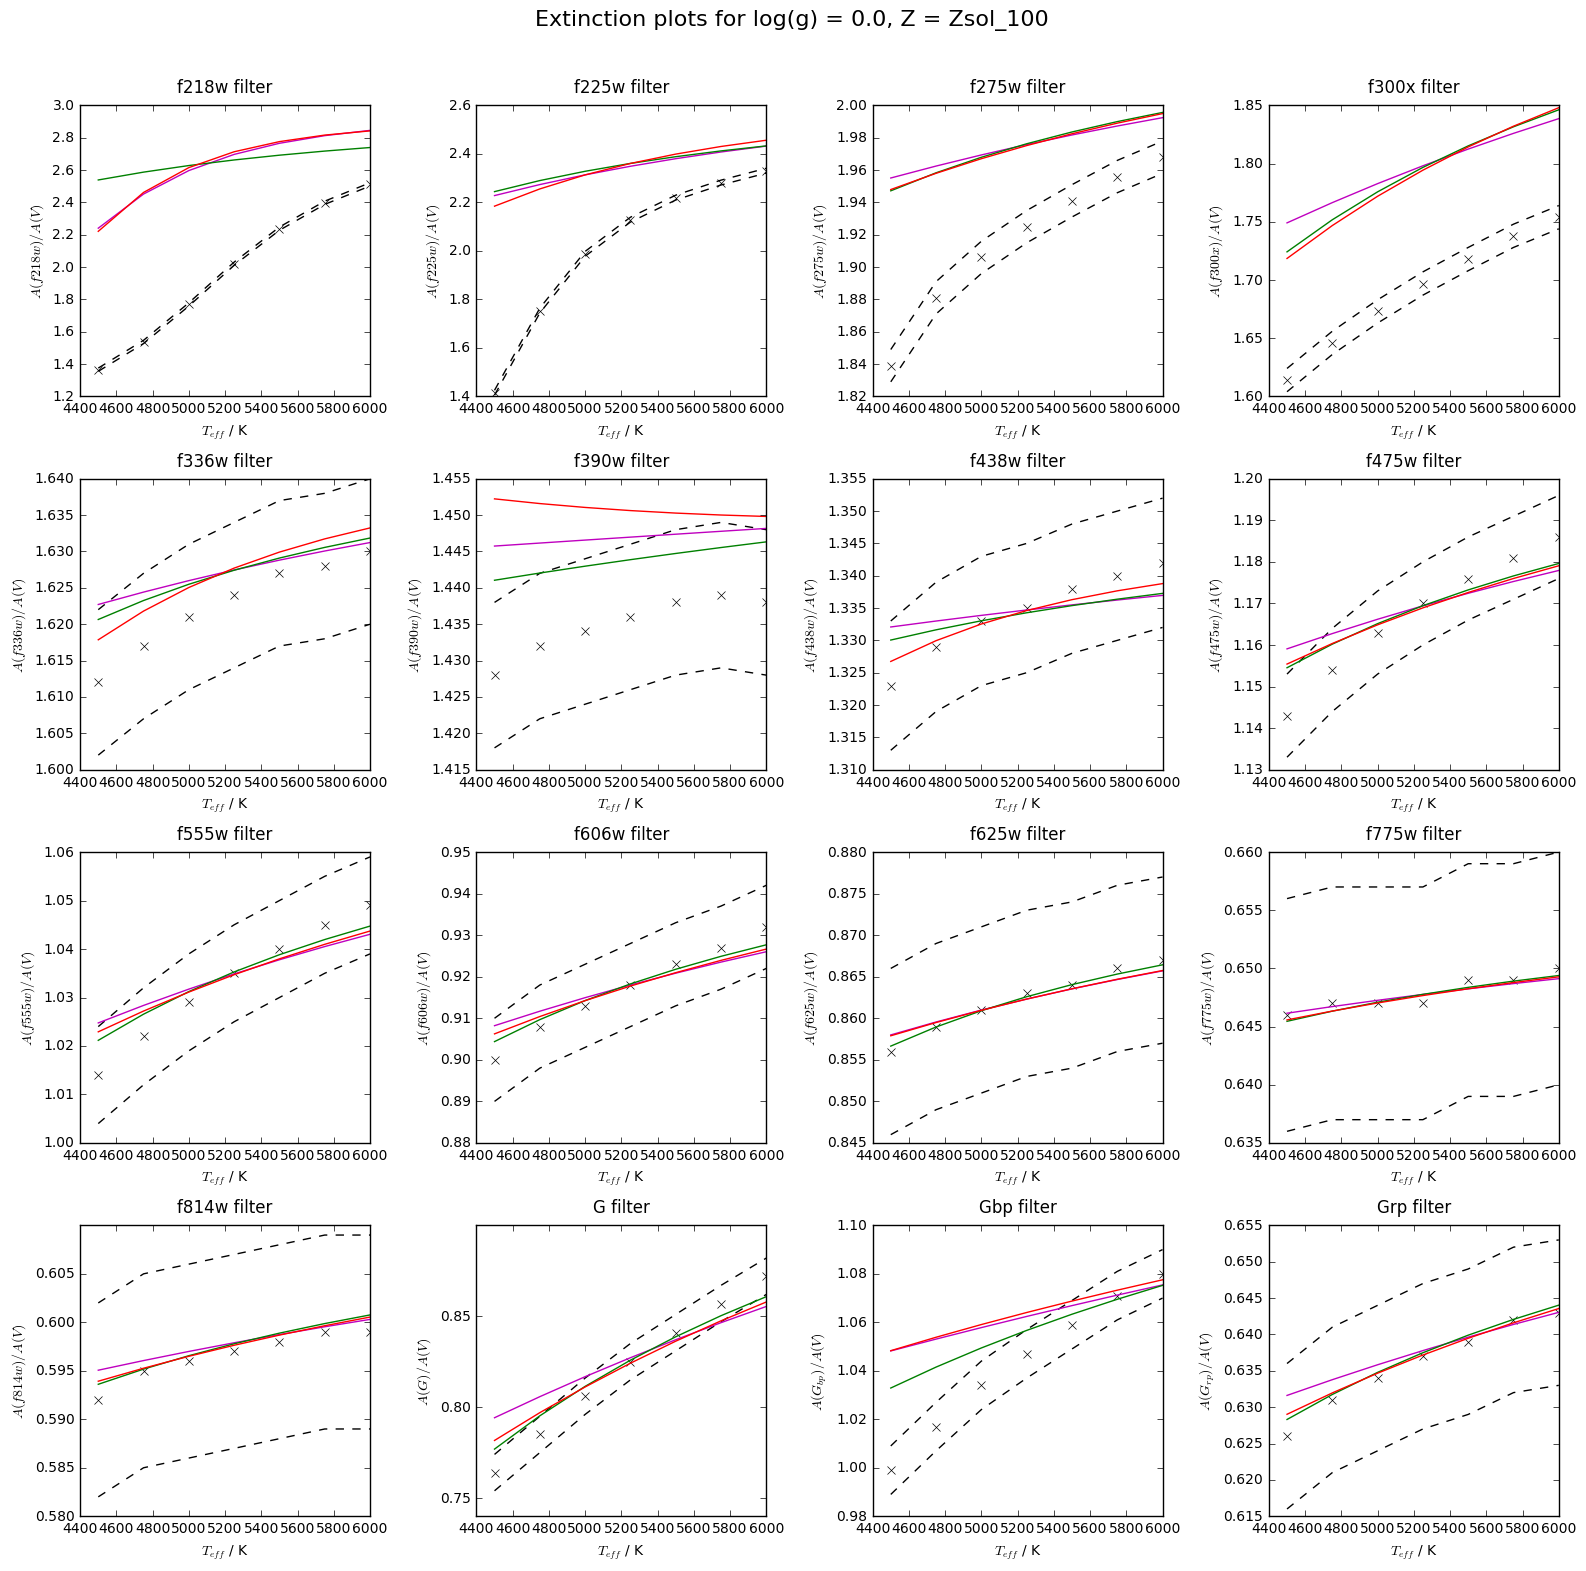


 Writing complete for log(g) = 0.0, Z = sol_100 configuration, END OF FUNCTION WRITING!!!


In [132]:
# If finished fitting (i.e. log(g) not equal to 5.0), DON'T run previous cell!!!

# Test solar metallicity fit on BOTH metallicity scenarios
#filter_curve_plot_write(comb_dict_zs_4500K,comb_dict_z2_4500K,combined_list_coef_cov_zs_4500K,'5.0','solar','4500K',exp_bounds,pow_bounds,spp_bounds,comb_filter_str,'HubWFC','Hub_graphs','n','y')
filter_curve_plot_write(comb_dict_zs_4500K,comb_dict_z2_4500K,combined_list_coef_cov_z2_4500K,'5.0','sol_100','4500K',exp_bounds,pow_bounds,spp_bounds,comb_filter_str,'HubWFC','Hub_graphs','n','y',4400,6000)
#,4400,6000

In [21]:
# Create coefficient summary text file for power law
# filename options:
# IN: metallicity: solar, sol_100
# OUT: metallicity: solar, solar/100
"""
print len(comb_filter_str)
make_coeffs_summary('HubWFC/','Teff_AHub_gaia_gen_fit_logg=5.0_sol_100_numbers.txt','coeffs_hub_gaia_power.txt',comb_filter_str,'5.0','solar/100','a')
"""

# low-Teff: log(g) affects A(filter)/A(V), i.e. A(Teff) becomes A(Teff,log(g))
# -> find law for log(g) effects
# N.B.: log(g) = consts. x (M(R*)/(R*)^2)
# Linear? Girardi et al. (2008) use giant Teff law: Teff(log(g)) = 3250 + 500log(g)
# For my values of log(g) (= 0 to 5), this gives a range of (3250 <= Teff <= 5750)
# Take our working definition of 0.01 'error' as a limit on log(g) effects

#print ' \t Full-Data Dictionary'
#low_logg_law_trunc(comb_dict_zs,0.01)
print '\n \t Teff >= 4500K Data Dictionary'
low_logg_law_trunc(comb_dict_zs_4500K,0.01)


 	 Teff >= 4500K Data Dictionary
Teff= 4500.0 , log(g)= 0.0 , column  3 , difference= 0.114
	Teff= 4500.0 , log(g)= 0.0 , column  4 , difference= 0.461
	Teff= 4500.0 , log(g)= 0.0 , column  5 , difference= 0.181
	Teff= 4500.0 , log(g)= 0.0 , column  6 , difference= 0.045
	Teff= 4500.0 , log(g)= 0.0 , column  8 , difference= 0.016
	Teff= 4500.0 , log(g)= 0.0 , column  10 , difference= 0.018
	Teff= 4500.0 , log(g)= 0.0 , column  17 , difference= 0.014
	Teff= 4750.0 , log(g)= 0.0 , column  3 , difference= 0.178
	Teff= 4750.0 , log(g)= 0.0 , column  4 , difference= 0.464
	Teff= 4750.0 , log(g)= 0.0 , column  5 , difference= 0.076
	Teff= 4750.0 , log(g)= 0.0 , column  6 , difference= 0.035
	Teff= 4750.0 , log(g)= 0.0 , column  8 , difference= 0.013
	Teff= 4750.0 , log(g)= 0.0 , column  10 , difference= 0.015
	Teff= 4750.0 , log(g)= 0.0 , column  17 , difference= 0.015
	Teff= 5000.0 , log(g)= 0.0 , column  3 , difference= 0.213
	Teff= 5000.0 , log(g)= 0.0 , column  4 , difference= 0.347
	Te

Dictionary size:  76
Shape of arrays: 
(7L, 18L) 9750.0
(7L, 18L) 9500.0
(7L, 18L) 9250.0
(8L, 18L) 9000.0
(8L, 18L) 8750.0
(8L, 18L) 8500.0
(9L, 18L) 8250.0
(9L, 18L) 8000.0
(9L, 18L) 7750.0
(10L, 18L) 7500.0
(10L, 18L) 7250.0
(10L, 18L) 7000.0
(10L, 18L) 6750.0
(10L, 18L) 6500.0
(10L, 18L) 6250.0
(11L, 18L) 6000.0
(11L, 18L) 5750.0
(11L, 18L) 5500.0
(11L, 18L) 5250.0
(1L, 18L) 50000.0
(11L, 18L) 5000.0
(2L, 18L) 49000.0
(2L, 18L) 48000.0
(11L, 18L) 4750.0
(2L, 18L) 47000.0
(2L, 18L) 46000.0
(2L, 18L) 45000.0
(11L, 18L) 4500.0
(2L, 18L) 44000.0
(2L, 18L) 43000.0
(11L, 18L) 4250.0
(2L, 18L) 42000.0
(2L, 18L) 41000.0
(2L, 18L) 40000.0
(11L, 18L) 4000.0
(3L, 18L) 39000.0
(3L, 18L) 38000.0
(11L, 18L) 3750.0
(3L, 18L) 37000.0
(3L, 18L) 36000.0
(3L, 18L) 35000.0
(11L, 18L) 3500.0
(3L, 18L) 34000.0
(3L, 18L) 33000.0
(3L, 18L) 32000.0
(4L, 18L) 31000.0
(4L, 18L) 30000.0
(4L, 18L) 29000.0
(4L, 18L) 28000.0
(4L, 18L) 27000.0
(5L, 18L) 26000.0
(5L, 18L) 25000.0
(5L, 18L) 24000.0
(5L, 18L) 23000.

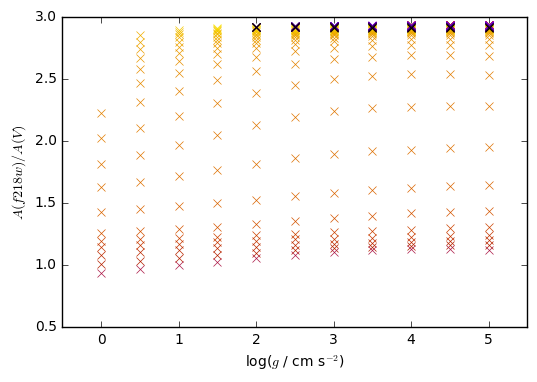

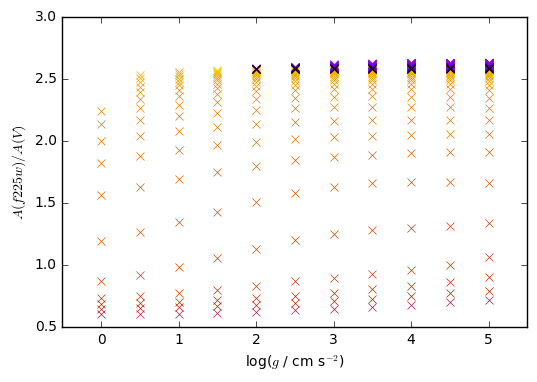

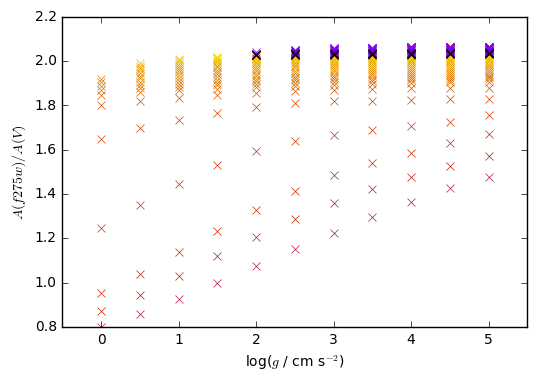

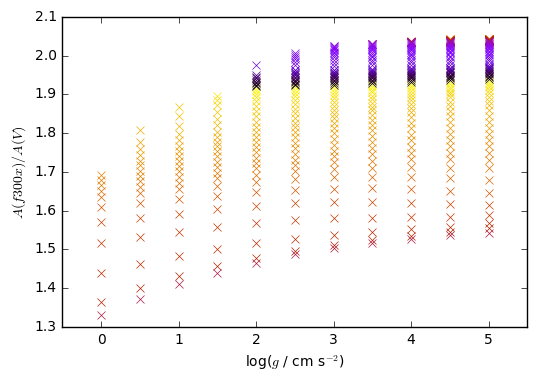

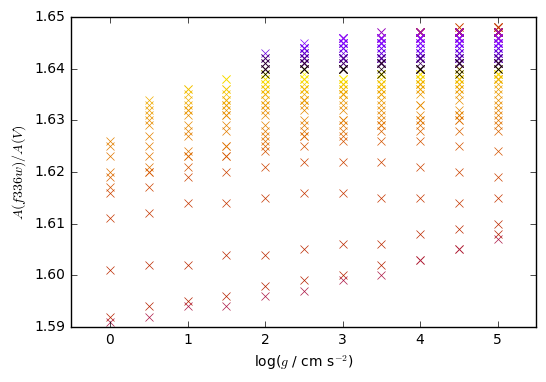

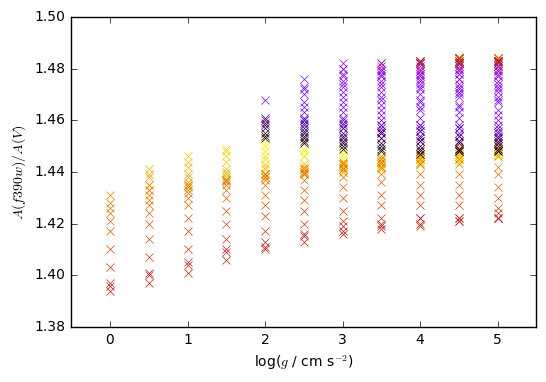

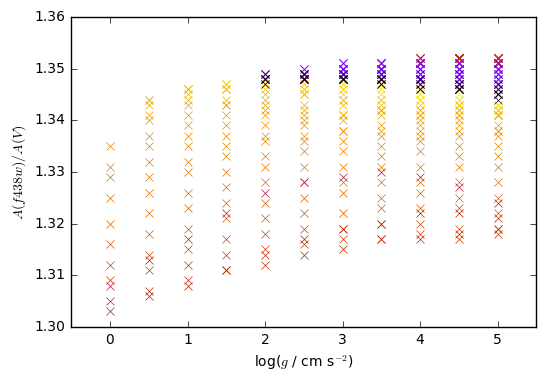

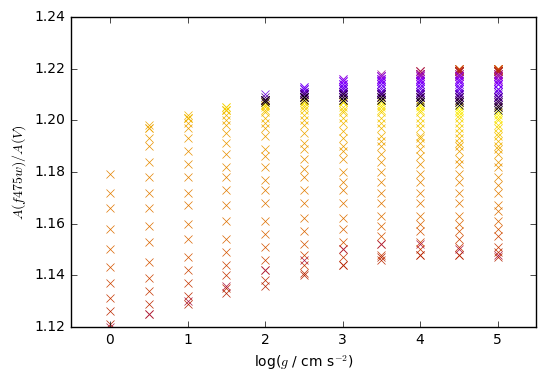

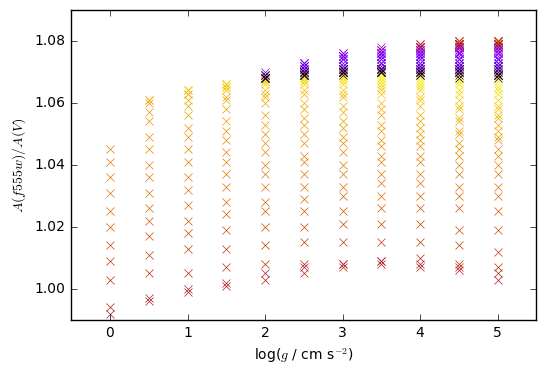

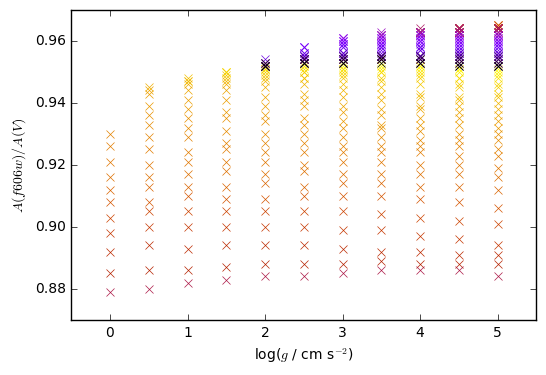

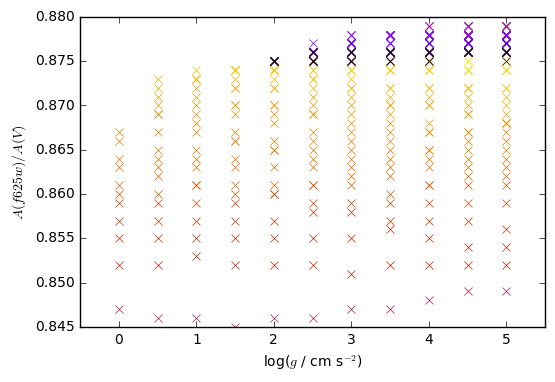

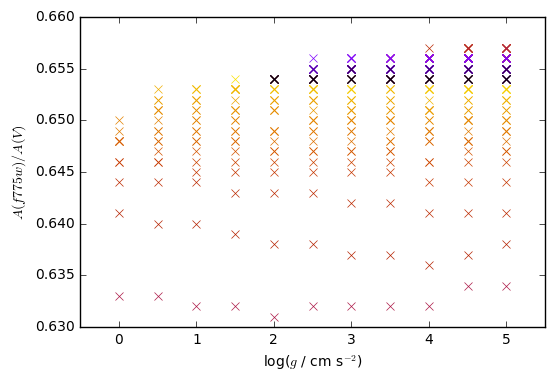

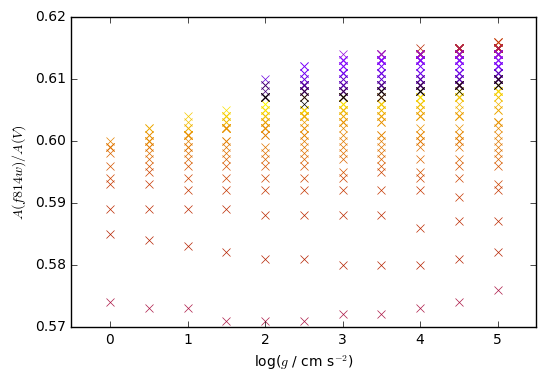

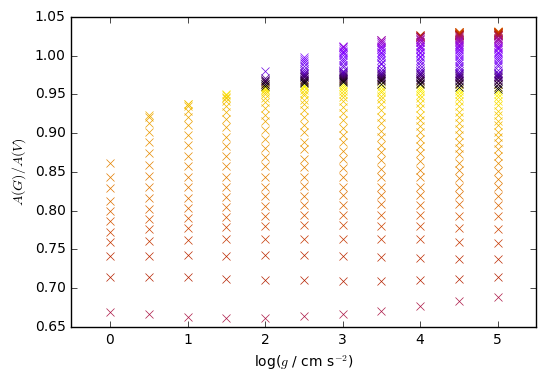

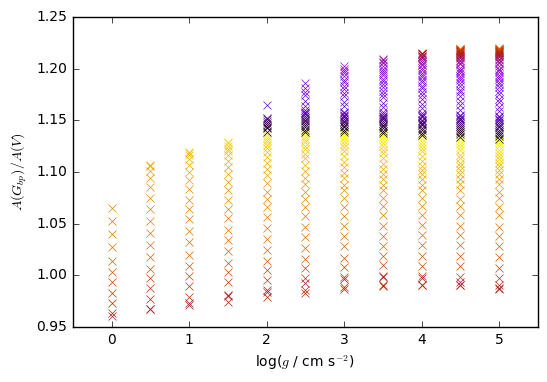

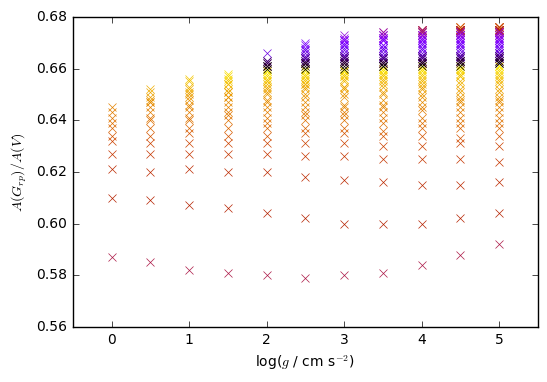

"\n# plot all 3 filters against Teff together\nfig,ax = plt.subplots()\nax.set_xlabel(var_names[0])\nax.set_ylabel('A(filter)')\nax.plot(Teff_5_zs,A_G_5_zs,'g', label = 'log(g) = 5, $A(G)$ curve')\nax.plot(Teff_5_zs,A_Gbp_5_zs,'b', label = 'log(g) = 5, $A(G_{bp})$ curve')\nax.plot(Teff_5_zs,A_Grp_5_zs,'r', label = 'log(g) = 5, $A(G_{rp})$ curve')\nplt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))\nplt.show()\n#fig.savefig('gaia_spectra/gaia_graphs/Aall_vs_Teff.pdf', bbox_inches='tight')\n"

In [178]:
var_names_comb = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(f218w)/A(V)$','$A(f225w)/A(V)$','$A(f275w)/A(V)$','$A(f300x)/A(V)$','$A(f336w)/A(V)$','$A(f390w)/A(V)$','$A(f438w)/A(V)$','$A(f475w)/A(V)$','$A(f555w)/A(V)$','$A(f606w)/A(V)$','$A(f625w)/A(V)$','$A(f775w)/A(V)$','$A(f814w)/A(V)$','$A(G)/A(V)$','$A(G_{bp})/A(V)$','$A(G_{rp})/A(V)$']
print 'Dictionary size: ',len(comb_dict_Teff_zs)
print 'Shape of arrays: '
for key in reversed(sorted(comb_dict_Teff_zs.iterkeys())):
    print comb_dict_Teff_zs[key].shape, key
for i in range(2,len(comb_dict_Teff_zs['4500.0'][0,:])):
    fig, ax = plt.subplots()
    col_map = plt.cm.gnuplot
    #plt.gca().set_color_cycle([col_map(i) for i in np.linspace(0, 1, len(Teff_vals))])
    #gnuplot gist_ncar
    ax.set_xlim(-0.5,5.5)
    #ax.set_xlim(1.99,2.11)
    dict_2D_plot(comb_dict_Teff_zs,ax,2,(i+1),var_names_comb,col_map)
    save_str = 'A' + comb_filter_str[i-2] +'_vs_logg_at_diff_Teff_zs.pdf' #_cut_4500K_zoom
    #ax.set_xlabel(var_names[0])
    #ax.set_ylabel('A(' + comb_filter_str[i-2] + ')')
    fig.savefig(save_str, bbox_inches='tight')
"""
# plot all 3 filters against Teff together
fig,ax = plt.subplots()
ax.set_xlabel(var_names[0])
ax.set_ylabel('A(filter)')
ax.plot(Teff_5_zs,A_G_5_zs,'g', label = 'log(g) = 5, $A(G)$ curve')
ax.plot(Teff_5_zs,A_Gbp_5_zs,'b', label = 'log(g) = 5, $A(G_{bp})$ curve')
ax.plot(Teff_5_zs,A_Grp_5_zs,'r', label = 'log(g) = 5, $A(G_{rp})$ curve')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
#fig.savefig('gaia_spectra/gaia_graphs/Aall_vs_Teff.pdf', bbox_inches='tight')
"""

In [53]:
"""
exp_fit_A_logg5, covarr_A_logg5_ef = curve_fit(exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-5.], [0., 1., 5.]))
pow_fit_A_logg5, covarr_A_logg5_pow = curve_fit(single_poly,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.0e+08,-5.,-3.], [1., 1., 4.]))
spp_exp_fit_A_logg5, covarr_A_logg5_spp = curve_fit(single_poly_plus_exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-4.,-5.], [1.,1.,2.,1.]))
#log_fit_A_logg5, covarr_A_logg5_lf = curve_fit(log_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.,5.0e-07,-5.], [10., 10., 5.]))

fig, ax = plt.subplots()
ax.set_xlabel(var_names[0])
ax.set_ylabel(var_names[4])

ax.plot((A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4],'k',label='Data')
ax.plot((A_X_zs_gfix['5.0'])[:,0],((A_X_zs_gfix['5.0'])[:,4] - 0.01),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.01)')
ax.plot((A_X_zs_gfix['5.0'])[:,0],((A_X_zs_gfix['5.0'])[:,4] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
ax.plot((A_X_zs_gfix['5.0'])[:,0],exp_func((A_X_zs_gfix['5.0'])[:,0],*exp_fit_A_logg5),'m',label=fit_types[0])
ax.plot((A_X_zs_gfix['5.0'])[:,0],single_poly((A_X_zs_gfix['5.0'])[:,0],*pow_fit_A_logg5),'g',label=fit_types[1])
ax.plot((A_X_zs_gfix['5.0'])[:,0],single_poly_plus_exp_func((A_X_zs_gfix['5.0'])[:,0],*spp_exp_fit_A_logg5),'r',label=fit_types[2])

#ax.set_xlim(3000,10000)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
fig.savefig('gaia_spectra/gaia_graphs/AGrp_logg=5.0_Teff_fit_plot.pdf', bbox_inches='tight')
"""

"\nexp_fit_A_G5zs, covarr_A_G5zs_ef = curve_fit(exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-5.], [0., 1., 5.]))\npow_fit_A_G5zs, covarr_A_G5zs_pow = curve_fit(single_poly,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.0e+08,-5.,-3.], [1., 1., 4.]))\nspp_exp_fit_A_G5zs, covarr_A_G5zs_spp = curve_fit(single_poly_plus_exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-4.,-5.], [1.,1.,2.,1.]))\n#log_fit_A_G5zs, covarr_A_G5zs_lf = curve_fit(log_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.,5.0e-07,-5.], [10., 10., 5.]))\n\nfig, ax = plt.subplots()\nax.set_xlabel(var_names[0])\nax.set_ylabel(var_names[4])\n\nax.plot((A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4],'k',label='Data')\nax.plot((A_X_zs_gfix['5.0'])[:,0],((A_X_zs_gfix['5.0'])[:,4] - 0.01),'k',linestyle='-.',label='Data lower accuracy limi

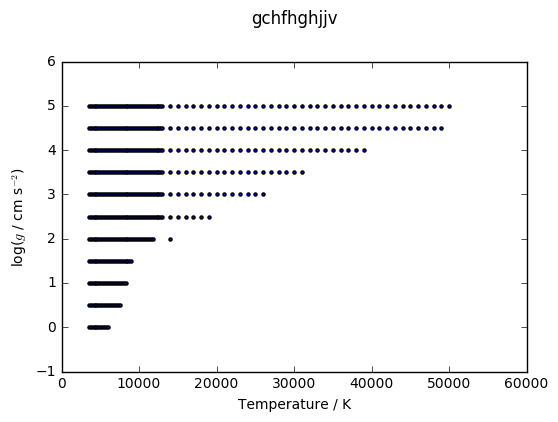

In [44]:
fig, ax = plt.subplots()
#ax.axhline(y=5.0, color='m', linestyle='--')
# Create a continuous norm to map from data points to colors | np.log10((Dthm+1).min()),np.log10((Dthm+1).max())
ax.scatter(T_Av0zs,log_g_Av0zs,marker='.')
ax.set_xlabel('Temperature / K')
ax.set_ylabel('log($g$ / cm s$^{-2}$)')
#ax.set_xlim(['5.02, 0.1])
#ax.set_ylim([0, 0.1])
#plt.show()
#ax.set_title('gchfhghjjv', y=1.1)
fig.savefig('gaia_spectra/gaia_graphs/hgchgftf.pdf', bbox_inches='tight')